In [23]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

def check_read_inside_region(start, seq, region):
        read_end = start + len(seq)
        region_start = int(region.split(":")[1].split("-")[0])
        region_end = int(region.split(":")[1].split("-")[1])
        if start >= region_start and read_end <= region_end:
            return "in"
        else: 
            return "overlap"

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
path_to_read_data = "/media/hieunguyen/GSHD_HN01/raw_data/reads_from_450_regions_with_readname_TMDfull"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

mode = "all"

metadata = pd.read_csv("analytical_LOD_TF 1.csv")
path_to_main_output = os.path.join(outdir, PROJECT, output_version)
path_to_03_output = os.path.join(path_to_main_output, "PANCANCER03_output")
path_to_04_output = os.path.join(path_to_main_output, "PANCANCER04_output")
os.system(f"mkdir -p {path_to_04_output}")

all_files = [item for item in pathlib.Path(path_to_03_output).glob("*.candi_reads.csv")]
all_read_files = [item for item in pathlib.Path(path_to_03_output).glob("*.read_classification.csv")]

##### read countdf: raw count and in-read count number. 
if os.path.isfile(os.path.join(path_to_03_output, "all_count.csv")) == False:
    all_samples = []
    raw_counts = []
    in_read_counts = []

    for file in tqdm(all_read_files):
        tmpdf = pd.read_csv(file)
        raw_count = tmpdf.shape[0]
        in_read_count = tmpdf[tmpdf["read_overlap_rate"] == "in"].shape[0]
        all_samples.append(file.name.replace(".read_classification.csv", ""))
        raw_counts.append(raw_count)
        in_read_counts.append(in_read_count)

    countdf = pd.DataFrame({"SampleID": all_samples, "raw_count": raw_counts, "in_read_count": in_read_counts})
    countdf.to_csv(os.path.join(path_to_03_output, "all_count.csv"))
else:
    print(f"Countdf existst, reading in from {os.path.join(path_to_03_output, 'all_count.csv')} ...")
    countdf = pd.read_csv(os.path.join(path_to_03_output, "all_count.csv"), index_col = [0])

all_samples = []
all_mean_candi_reads = []
for file in all_files:
    tmpdf = pd.read_csv(file)
    mean_candi_reads = tmpdf.candi_reads.mean()
    all_samples.append(file.name.split(".")[0])
    all_mean_candi_reads.append(mean_candi_reads)

candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]
candidf = candidf.merge(metadata, right_on = "Sample", left_on = "SampleID")
candidf = candidf.fillna(0)
candidf["LABEL"] = candidf["LABEL"].apply(lambda x: "CRC" if x == "Colorectal cancer" else x.split(" ")[0])
candidf["detail_label"] = candidf["LABEL"]
candidf["Label"] = candidf["LABEL"].apply(lambda x: "Control" if x == "Healthy" else "Cancer")
convert_ratio = {
    '5': 5, 
    'HC': 0, 
    '100': 100, 
    '50': 50, 
    '0.5': 0.5, 
    '15': 15, 
    '1': 1, 
    '25': 25
}
candidf["spike-in"] = candidf["spike-in"].apply(lambda x: convert_ratio[str(x)])

candidf.to_excel(os.path.join(path_to_04_output, "candi_reads_all_{}_vs_control.xlsx".format("PAN_CANCER")), index = False)


Countdf existst, reading in from /media/hieunguyen/HNSD_mini/outdir/TMD450_TCGA_data_analysis/20240910/PANCANCER03_output/all_count.csv ...


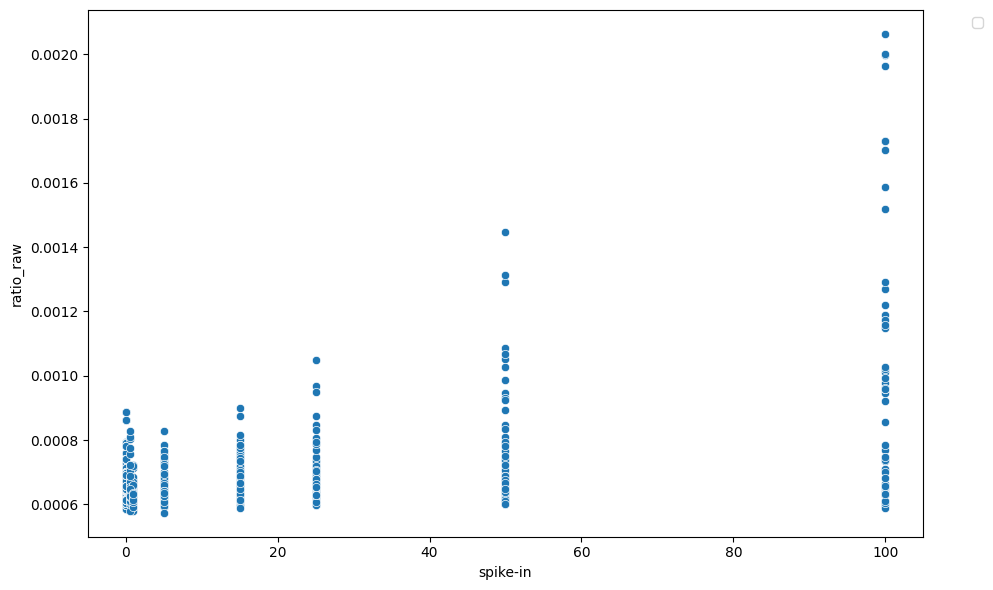

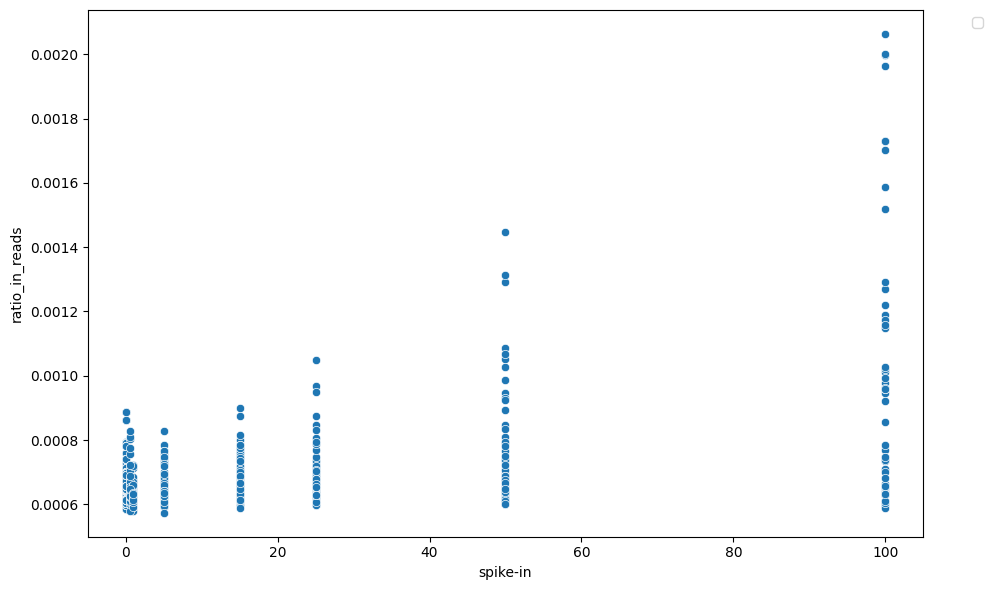

In [24]:
input_cancer_class = "PAN_CANCER"
plt.figure(figsize=(10, 6))
sns.scatterplot(data = candidf, x = "spike-in", y = "ratio_raw")

        
figname1 = f"LOD_samples_{input_cancer_class}_raw_ratio.svg"
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(path_to_04_output, figname1), format='svg')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data = candidf, x = "spike-in", y = "ratio_in_reads")

figname2 = f"LOD_samples_{input_cancer_class}_raw_in_reads.svg"
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(path_to_04_output, figname2), format='svg')
plt.show()